**工程完整代码与更多演示，可参见 GitHub Repo: [ThreeFish-AI/deep-learning](https://github.com/ThreeFish-AI/deep-learning)，或关注博主个人主页：[三余知行](https://threefish.site/trend)**

In [1]:
import numpy as np

def sigmoid(x):
    """S 型函数"""
    return 1 / (1 + np.exp(-x))

def softmax(x):
    """归一化指数函数"""
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)  # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))

In [2]:
def cross_entropy_error(y, t):
    """交叉熵误差函数"""
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 监督数据是 one-hot-vector 的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [18]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [3]:
def _numerical_gradient_1d(f, x):
    """梯度函数
    用数值微分求导法，求 f 关于 1 组参数的 1 个梯度。

    Args:
        f: 损失函数
        x: 参数（1 组参数，1 维数组）
    Returns:
        grad: 1 组梯度（1 维数组）
    """
    h = 1e-4                    # 0.0001
    grad = np.zeros_like(x)     # 生成和 x 形状相同的数组，用于存放梯度（所有变量的偏导数）

    for idx in range(x.size):   # 挨个遍历所有变量
        xi = x[idx]             # 取第 idx 个变量
        x[idx] = float(xi) + h
        fxh1 = f(x)             # 求第 idx 个变量增大 h 所得计算结果

        x[idx] = xi - h
        fxh2 = f(x)             # 求第 idx 个变量减小 h 所得计算结果

        grad[idx] = (fxh1 - fxh2) / (2*h)  # 求第 idx 个变量的偏导数
        x[idx] = xi             # 还原第 idx 个变量的值
    return grad

In [4]:

def numerical_gradient_2d(f, X):
    """梯度函数（批量）
    用数值微分求导法，求 f 关于 n 组参数的 n 个梯度。

    Args:
        f: 损失函数
        X: 参数（n 组参数，2 维数组）
    Returns:
        grad: n 组梯度（2 维数组）
    """
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)

        return grad

In [28]:
class SimpleNet(object):
    """一个简单的演示神经网络 SimpleNet，用于演示神经网络对手写数字图像识别任务的自动学习和推理过程。

    Attributes:
        params: 存放 SimpleNet 网络权重参数与偏置参数
            W1: 第 1 层网络的权重参数
            b1: 第 1 层网络的偏置参数
            W2: 第 2 层网络的权重参数
            b2: 第 2 层网络的偏置参数
    """

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """SimpleNet 的初始化函数

        Args:
            input_size:      输入层（第 0 层）神经元个数（神经网络入参个数）
            hidden_size:     隐藏层（第 1 层）神经元个数
            output_size:     输出层（第 2 层）神经元个数（神经网络出参个数）
            weight_init_std: 用于初始化权重参数的高斯分布的标准差
        """
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(input_size, hidden_size)    # 用高斯分布进行 W1 参数的随机初始化
        self.params['b1'] = np.zeros(hidden_size)       # 用 0 进行 b1 参数的初始化
        self.params['W2'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)   # 用高斯分布进行 W2 参数的随机初始化
        self.params['b2'] = np.zeros(output_size)       # 用 0 进行 b2 参数的初始化

    def predict(self, x):
        """推理函数
            识别数字图像代表的数值。

        Args:
            x: 图像像素值数组（图像数据）
        Returns:
            y: 推理结果，图像代表的数值
        """
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        s1 = np.dot(x, W1) + b1
        a1 = sigmoid(s1)
        s2 = np.dot(a1, W2) + b2
        y = softmax(s2)

        return y

    def loss(self, x, t):
        """损失函数（交叉熵误差）

        Args:
            x: 输入数据，即图像数据
            t: 监督数据，即正确解标签
        Returns:
            loss: 推理的损失值
        """
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def numerical_gradient(self, x, t):
        """梯度函数（数值微分求导法）

        Args:
            x: 输入数据，即图像数据
            t: 监督数据，即正确解标签
        Returns:
            grads: 误差函数关于当前权重参数的梯度
        """
        def loss_W(W):
            """损失值关于权重参数的函数
            """
            return self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient_2d(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient_2d(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient_2d(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient_2d(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        """梯度函数（误差逆传播求导法）

        Args:
            x: 输入数据，即图像数据
            t: 监督数据，即正确解标签（one hot 表示）
        Returns:
            grads: 误差函数关于当前权重参数的梯度
        """

        # W1: (784, 50), W2: (50, 10)
        W1, W2 = self.params['W1'], self.params['W2']
        # b1: (50,), b2: (10,)
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]

        # forward: 前向传播
        # a1: (batch_num, 50) = (batch_num, 784) x (784, 50) + (50,)
        a1 = np.dot(x, W1) + b1
        # z1: (batch_num, 50)
        z1 = sigmoid(a1)
        # a2: (batch_num, 10) = (batch_num, 50) x (50, 10) + (10,)
        a2 = np.dot(z1, W2) + b2
        # y: (batch_num, 10)
        y = softmax(a2)

        # backward：逆向传播（BP 算法，误差逆传播求导）
        dy = (y - t) / batch_num
        # grads['W2']: (50, 10) = (50, batch_num) x (batch_num, 10)
        grads['W2'] = np.dot(z1.T, dy)
        # grads['b2']: (10,) = (batch_num, 10)
        grads['b2'] = np.sum(dy, axis=0)

        # da1: (batch_num, 50) = (batch_num, 10) x (10, 50)
        da1 = np.dot(dy, W2.T)
        # dz1：(batch_num, 50)
        dz1 = sigmoid_grad(a1) * da1
        # grads['W1']: (784, 50) = (784, batch_num) x (batch_num, 50)
        grads['W1'] = np.dot(x.T, dz1)
        # grads['b1']: (50,) = (batch_num, 50)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

    def accuracy(self, x, t):
        """精准度函数
        求推理正确的百分比。
        Args:
            x: 输入数据，即图像数据
            t: 监督数据，即正确解标签
        Returns:
            accuracy: 推理的精准度
        """
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

In [38]:
network = SimpleNet(input_size=784, hidden_size=50, output_size=10)

In [8]:
def one_hot_label(X):
    """将标签数据批量转换为长度为 10 的独热数组"""
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
    return T

In [9]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
# "data" 是图像数据，"target" 是标签数据
# 图像数据除以 255.0 进行归一化
# 标签数据转换为 one-hot 表示
X, y = mnist["data"].to_numpy().astype(np.float32) / 255.0, one_hot_label(mnist["target"].to_numpy().astype(int))
# 此处直接取前 60000 个样例为训练集，后 10000 个样例为测试集
x_train, t_train, x_test, t_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [13]:
def mini_batch(x, t, batch_size=100):
    """从 (x, t) 随机选取 mini-batch 数据

    Args:
        x: 数据集
        t: 标签集
        batch_size: mini-batch 大小
    Returns:
        x_batch: mini-batch 数据
        t_batch: mini-batch 标签
    """

    train_size = x.shape[0]
    batch_mask = np.random.choice(train_size, batch_size)

    x_batch = x[batch_mask]
    # 将批量标签值转换为 array[int] 表示，用于计算交叉熵误差时提取正确推理值
    t_batch = t[batch_mask]

    return x_batch, t_batch

# mini batch input, mini batch label
x_batch, t_batch = mini_batch(x_train, t_train, 100)

In [14]:
t_train, t_test

(array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]),
 array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [15]:
grad = network.numerical_gradient(x_batch, t_batch)

In [16]:
grad

{'W1': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'b1': array([-1.11528364e-05, -4.42279213e-05,  1.98326533e-05, -9.25869115e-05,
        -1.52292936e-04, -9.02327568e-05, -3.47843154e-05, -3.53453999e-04,
         1.34107960e-04, -1.40385237e-05,  1.14508789e-04,  3.22159432e-05,
         1.02062765e-04, -1.63044414e-04, -5.24863641e-04,  3.51757359e-04,
         1.23900246e-04,  6.19227603e-05,  2.50934717e-05, -5.00538500e-06,
         2.70275380e-05, -5.20520271e-05, -2.49449394e-05,  3.67389410e-04,
         1.76274446e-04, -2.71058513e-04,  7.06952585e-05, -1.03037947e-04,
         1.08086091e-04,  2.67175635e-04,  1.99169476e-04,  2.71485947e-04,
        -2.85207435e-05, -5.08196707e-05,  1.46662560e-04,  2.56010768e-06,
         2.10762185e-04,  2.03451198e-04, -3.59691146e-

In [17]:
learning_rate = 0.1

# 依次更新权重参数：W1, b1, W2, b2
for key in ('W1', 'b1', 'W2', 'b2'):
    # 将相应参数沿梯度方向进行微小更新
    network.params[key] -= learning_rate * grad[key]

In [39]:
iters_num = 10000           # 设定迭代次数：让 SimpleNet 对训练集进行 10000 次学习，每次学习随机选取 100 个样例
batch_size = 100            # 设定 mini-batch 的大小：每次从训练集中随机选取 100 个样例进行学习
learning_rate = 0.1         # 设定学习率：每次学习时更新权重参数的步长为 0.1

train_loss_list = []        # 记录训练过程中的损失值
train_acc_list = []         # 记录每轮学习后，神经网络在训练集上的识别精度
test_acc_list = []          # 记录每轮学习后，神经网络在测试集上的识别精度

# 每轮学习的迭代次数 = 训练集长度 / 每批长度
iter_per_epoch = max(x_train.shape[0] / batch_size, 1)

for i in range(iters_num):
    # 执行步骤 1
    x_batch, t_batch = mini_batch(x_train, t_train, batch_size)
    # 此处使用数值微分法实现的梯度计算仅供算法推导过程的演示，实际的训练中数值微分法的效率比较低下；
    # 笔者在 M1 Pro 机器上测试，每次迭代需要 10s 左右，整个过程约需要 27.7 hours。
    # grad = network.numerical_gradient(x_batch, t_batch)
    # 我们在 github 演示代码中提供了 BP 算法实现的梯度函数，整个训练过程不需要 1 min。
    grad = network.gradient(x_batch, t_batch)

    # 执行步骤 2
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 每轮（600 次）学习记录一次训练数据和测试数据的识别精度
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        # 记录训练过程中的损失值
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        print(f"train acc, test acc | {str(train_acc)}, {str(test_acc)}")

train acc, test acc | 0.09863333333333334, 0.0958
train acc, test acc | 0.8033166666666667, 0.8054
train acc, test acc | 0.8767333333333334, 0.8812
train acc, test acc | 0.8983833333333333, 0.9021
train acc, test acc | 0.908, 0.9114
train acc, test acc | 0.9137166666666666, 0.9166
train acc, test acc | 0.9195666666666666, 0.922
train acc, test acc | 0.9237833333333333, 0.9277
train acc, test acc | 0.92745, 0.929
train acc, test acc | 0.9311833333333334, 0.9327
train acc, test acc | 0.9337333333333333, 0.9357
train acc, test acc | 0.9368833333333333, 0.9381
train acc, test acc | 0.9389666666666666, 0.9394
train acc, test acc | 0.9404833333333333, 0.9415
train acc, test acc | 0.9425333333333333, 0.9432
train acc, test acc | 0.9447666666666666, 0.9443
train acc, test acc | 0.946, 0.9466


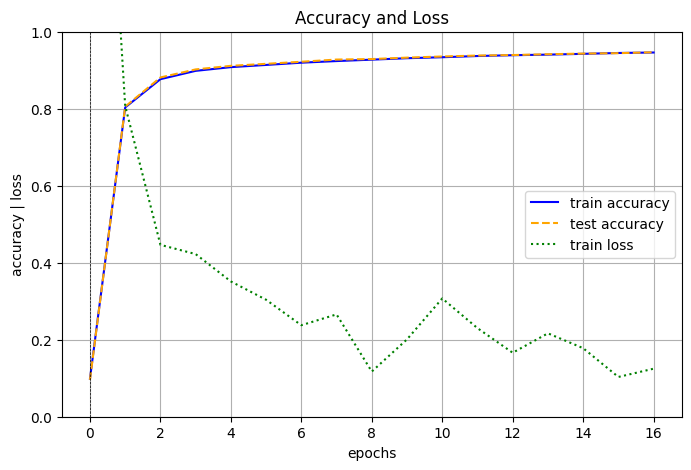

In [40]:
import matplotlib.pyplot as plt

# 绘制图形
plt.figure(figsize=(8, 5))
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train accuracy', color='blue')
plt.plot(x, test_acc_list, label='test accuracy',
         color='orange', linestyle='--')
plt.plot(x, train_loss_list, label='train loss', color='green', linestyle=':')
plt.title('Accuracy and Loss')
plt.xlabel('epochs')
plt.ylabel('accuracy | loss')
plt.ylim(0, 1.0)
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.grid()
plt.legend()
plt.show()

**工程完整代码与更多演示，可参见 GitHub Repo: [ThreeFish-AI/deep-learning](https://github.com/ThreeFish-AI/deep-learning)，或关注博主个人主页：[三余知行](https://threefish.site/trend)**